In [1]:
%load_ext autoreload
%autoreload 2
import anvil
import anvil.adaround

import torch
import torch.nn as nn
from torchvision.models import resnet18
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F
import copy
import torch.optim as optim
import os, pathlib

import matplotlib.pyplot as plt

base_path = pathlib.Path("/home/mpuscian/Desktop/repozytoria/MINI_projects/anvil/models/")
model_path = base_path.joinpath("cifar_model2.pth")
adaround_model_path = base_path.joinpath("adaround_model.pth")


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = resnet18(weights=None)
model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model.maxpool = nn.Identity()
model.fc = nn.Linear(512, 10)

sample_input = torch.randn(1, 3, 32, 32)

In [2]:
adaround_model = copy.deepcopy(model)
adaround_model.load_state_dict(torch.load(model_path, map_location=device))

conv_layers = []
for name, module in adaround_model.named_modules():
    if isinstance(module, nn.Conv2d):
        conv_layers.append(module)

quantizized_model = anvil.adaround.AdaRoundModelWrapper(adaround_model, sample_input)
h_alphas = quantizized_model.apply_adaround_to_conv_layers(reg_param=20, bitwidth=4)

Quantizing conv1


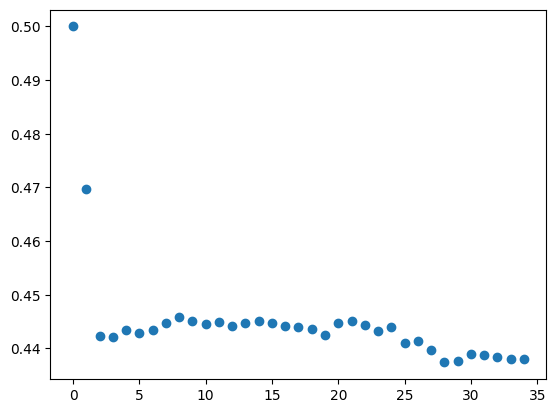

In [3]:
means = []
for h_alpha in h_alphas[0]:
    means.append(h_alpha.mean())
plt.scatter([i for i in range(len(means))], means)

In [4]:
conv1_weights = list(adaround_model.named_modules())[1][1].weight

In [5]:
conv1_weights.shape

torch.Size([64, 3, 3, 3])

In [ ]:
print(f"Unique weights: {torch.unique(conv1_weights).shape}")

Unique weights: torch.Size([1728])
